# TME 2 - Descende de gradient

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

# Implémentation des fonctions de coût

In [10]:

def mse(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return (x@w-y)**2

def reglog(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    y=np.where(y==-1,0,1) # On convertit les -1 en 0
    X=np.exp(-(x@w))
    return (np.sum((np.log(1+X)))-np.transpose(np.log(X))@(1-y))/len(x)

def mse_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return 2*np.transpose(x)@(x@w-y)/len(x)

def reglog_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    y=np.where(y==-1,0,y)
    pred=1/(1+np.exp(-(x@w)))
    return -np.transpose(x)@(y-pred)/len(x)
    

def check_fonctions():
    ## On fixe la seed de l'aléatoire pour vérifier les fonctions
    np.random.seed(0)
    datax, datay = gen_arti(epsilon=0.1)
    wrandom = np.random.randn(datax.shape[1],1)
    assert(np.isclose(mse(wrandom,datax,datay).mean(),0.54731,rtol=1e-4))
    assert(np.isclose(reglog(wrandom,datax,datay).mean(), 0.57053,rtol=1e-4))
    assert(np.isclose(mse_grad(wrandom,datax,datay).mean(),-1.43120,rtol=1e-4))
    assert(np.isclose(reglog_grad(wrandom,datax,datay).mean(),-0.42714,rtol=1e-4))
    np.random.seed()

check_fonctions()

# Vérification du gradient

In [11]:
def grad_check(f,f_grad,N): 
    datax, datay = gen_arti(epsilon=0.1,nbex=N)
    wrandom = np.random.randn(datax.shape[1],1)
    h=np.random.rand(len(datax[0]))*0.001

    f_x_plus_h=f(wrandom,datax+h,datay).mean() # Vraie valeur de f(x+h)
    approx=f(wrandom,datax,datay).mean()+h@f_grad(wrandom,datax,datay) # On approxime f(x+h) par Taylor

    return f_x_plus_h-approx.mean() # On regarde la différence

print(grad_check(mse,mse_grad,100),grad_check(reglog,reglog_grad,100))

0.011657834719837723 0.0007148046257600127


# Desecente de gradient

In [284]:
def descente_gradient(datax,datay,f_loss,f_grad,eps=10e-3,iter=100,init=0):
    datay = datay.reshape(-1,1)
    w=np.array([init]*len(datax[0]))
    w_list=[w]
    f_values=[f_loss(w_list[0],datax,datay).mean()]
    for i in range(iter):
        w=w-eps*f_grad(w,datax,datay).reshape(1,-1)
        w_list.append(w)
        f_values.append(f_loss(w_list[-1],datax,datay).mean())
    w_opt=w_list[np.argmin(f_values)].reshape(len(datax[0]),)

    return w_opt,w_list,f_values

# Implémentation de la descente de gradient sur le pb à 2 gaussiennes

#### 1) Avec la régression linéaire

Taux de classification pour la régression linéaire : 100.0%


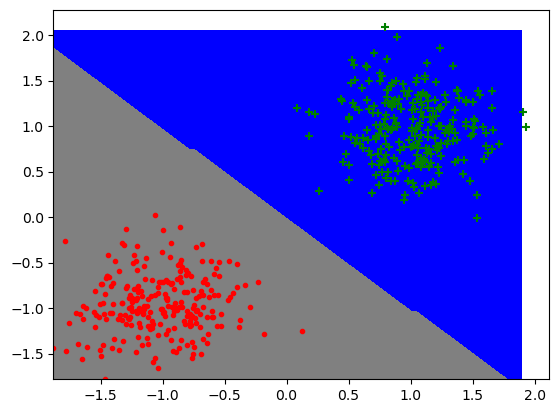

In [146]:
datax, datay = gen_arti(epsilon=0.1)
datay=datay.reshape(1,-1)
N=len(datax)//2

datax_train,datax_test=datax[:N],datax[N:] # Séparation en données d'entrainement et de test
datay_train,datay_test=datay[:,:N],datay[:,N:]
w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,mse,mse_grad) # Apprentissage
    
plt.figure()
## Visualisation des données de test et de la frontière de décision associée au vecteur de poids appris

plot_frontiere(datax_test,lambda x : np.sign(x.dot(w_opt)),step=100)
plot_data(datax_test,datay_test)

## Vérification numérique (en cas d'ambiguité sur la visualisation graphique)
y_hat=np.where(datax_test@w_opt>0,1,-1) # Prédiction
score=np.where(y_hat==datay_test,1,0).mean() # Comparaison entre labels prédits et véritables
print(f"Taux de classification pour la régression linéaire : {score*100}%") # Affichage de l'accuracy

On constate que tous les points sont bien classés.

0.048575824297239174


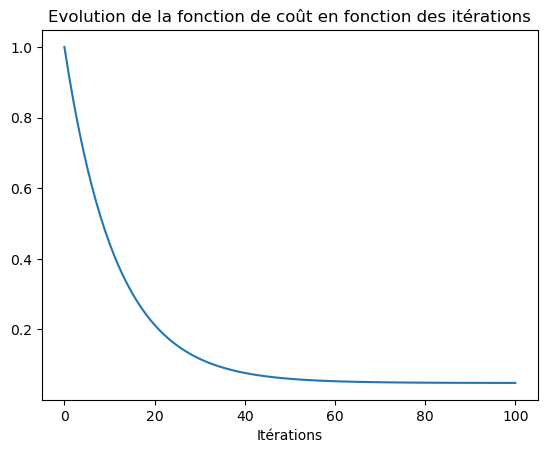

In [140]:
# Evolution de la fonction de coût en fonction des itérations

plt.plot(f_values)
plt.title("Evolution de la fonction de coût en fonction des itérations")
plt.xlabel("Itérations")

#### 2) Avec la régression logistique

Taux de classification pour la régression logistique : 100.0%


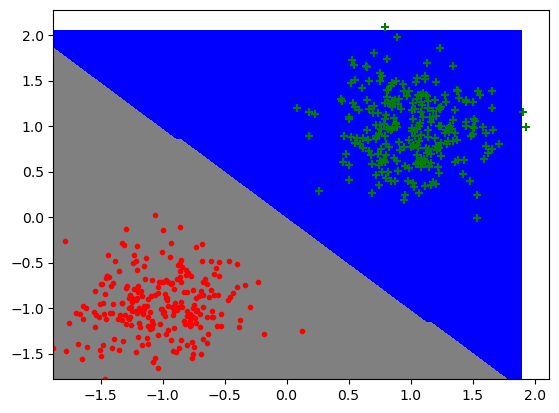

In [215]:
w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,reglog,reglog_grad) # Apprentissage
    
plt.figure()
## Visualisation des données de test et de la frontière de décision associée au vecteur de poids appris

plot_frontiere(datax_test,lambda x : np.sign(x.dot(w_opt)),step=100)
plot_data(datax_test,datay_test)

## Vérification numérique (en cas d'ambiguité sur la visualisation graphique)
y_hat=np.where(datax_test@w_opt>0,1,-1) # Prédiction
score=np.where(y_hat==datay_test,1,0).mean() # Comparaison entre labels prédits et véritables
print(f"Taux de classification pour la régression logistique : {score*100}%") # Affichage de l'accuracy

De même, la régression logistique permet à nouveau de correctement classer tous les points.

Text(0.5, 0, 'Itérations')

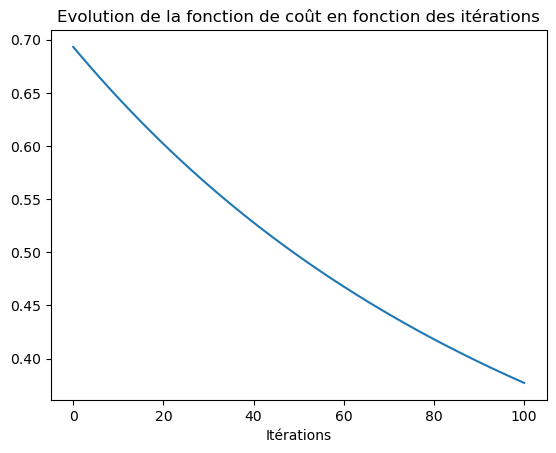

In [150]:
# Evolution de la fonction de coût en fonction des itérations

plt.plot(f_values)
plt.title("Evolution de la fonction de coût en fonction des itérations")
plt.xlabel("Itérations")

# Augmentation du pas de gradient

In [242]:
w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,mse,mse_grad,eps=0.5) # Passage du pas à 0.5 (par défaut 10e-3)

Text(0.5, 0, 'Itérations')

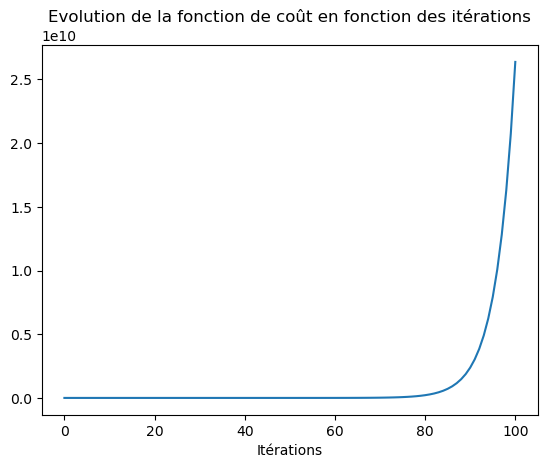

In [243]:
# Regardons l'influence de l'augmentation du pas sur la convergence de l'algorithme : 
plt.plot(f_values)
plt.title("Evolution de la fonction de coût en fonction des itérations")
plt.xlabel("Itérations")

On constate un phénomène de divergence.

# Cas d'un problème non séparable 

Taux de classification pour la régression linéaire : 79.2%


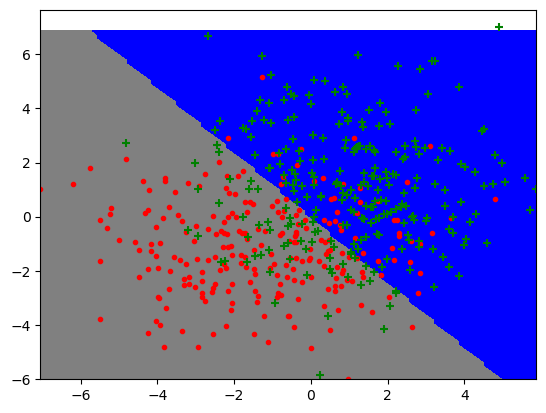

In [249]:
datax, datay = gen_arti(epsilon=2)
datay=datay.reshape(1,-1)
N=len(datax)//2

datax_train,datax_test=datax[:N],datax[N:] # Séparation en données d'entrainement et de test
datay_train,datay_test=datay[:,:N],datay[:,N:]
w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,mse,mse_grad) # Apprentissage
    
plt.figure()
## Visualisation des données de test et de la frontière de décision associée au vecteur de poids appris

plot_frontiere(datax_test,lambda x : np.sign(x.dot(w_opt)),step=100)
plot_data(datax_test,datay_test)

## Vérification numérique (en cas d'ambiguité sur la visualisation graphique)
y_hat=np.where(datax_test@w_opt>0,1,-1) # Prédiction
score=np.where(y_hat==datay_test,1,0).mean() # Comparaison entre labels prédits et véritables
print(f"Taux de classification pour la régression linéaire : {score*100}%") # Affichage de l'accuracy

L'algo semble être plutôt résistant au bruit (dans la mesure où celui-ci n'est pas assez grand pour rendre les deux classes indistinguables) 
En effet, la frontière de décision ainsi représentée semble la plupart du temps "optimale" (dans le sens où un humain tracerait vraisemblalement la même) dans ce contexte de non séparabilité

# Visualisation de la convergence de la descente de gradient

#### 1) Pour la régression linéaire

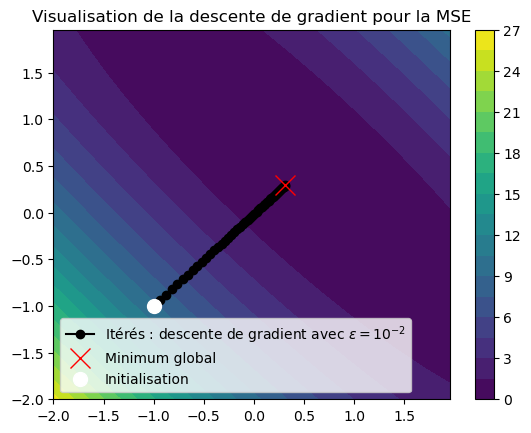

In [316]:

## Tirage d'un jeu de données aléatoire avec un bruit de 0.1
datax, datay = gen_arti(epsilon=0.1)
## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)

## Visualisation de la fonction de coût en 2D
plt.figure()
plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)

w_opt,w_list,f_values=descente_gradient(datax,datay,mse,mse_grad,eps=0.01,iter=50,init=-1) # Apprentissage

X1,Y1=[-1],[-1]
for k in range(1,len(w_list)):  
    X1.append(w_list[k][0][0])  
    Y1.append(w_list[k][0][1])

plt.plot(X1,Y1,'-o',color='black',label='Itérés : descente de gradient avec $\epsilon=10^{-2}$')
plt.plot(w_opt[0],w_opt[1],"x",color='red',markersize=15,label='Minimum global')
plt.plot(-1,-1,"o",color='white',markersize=10,label='Initialisation')
plt.title("Visualisation de la descente de gradient pour la MSE")
plt.colorbar()
plt.legend(loc=3)
    

#### 2) Pour la régression logistique

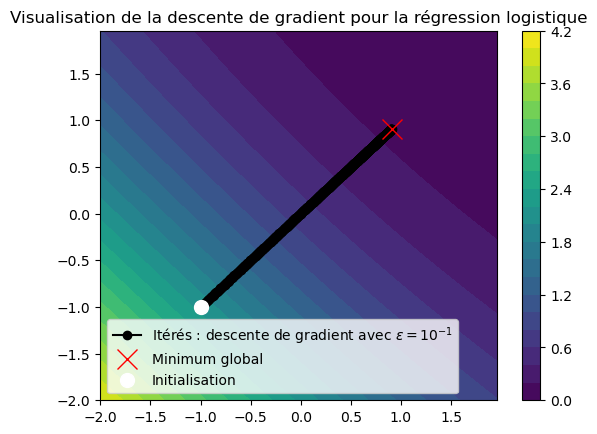

In [315]:
plt.figure()
plt.contourf(x_grid,y_grid,np.array([reglog(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)

w_opt,w_list,f_values=descente_gradient(datax,datay,reglog,reglog_grad,eps=0.01,iter=500,init=-1) # Apprentissage

X1,Y1=[-1],[-1]
for k in range(1,len(w_list)):  
    X1.append(w_list[k][0][0])  
    Y1.append(w_list[k][0][1])

plt.plot(X1,Y1,'-o',color='black',label='Itérés : descente de gradient avec $\epsilon=10^{-1}$')
plt.plot(w_opt[0],w_opt[1],"x",color='red',markersize=15,label='Minimum global')
plt.plot(-1,-1,"o",color='white',markersize=10,label='Initialisation')
plt.title("Visualisation de la descente de gradient pour la régression logistique")
plt.colorbar()
plt.legend(loc=3)